In [1]:
import os
import re
import json
from pprint import pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

with open('../titrations.json', 'r') as f:
    experiments = json.load(f)

pp(experiments)

{'Lauric Acid': ['./19_Validation/TitrationData/20191204_Lauric_Titration_2.csv',
                 './19_Validation/TitrationData/20191204_Lauric_Titration_4.csv',
                 './19_Validation/TitrationData/20191204_Lauric_Titration_3.csv',
                 './19_Validation/TitrationData/20191204_Lauric_Titration_5.csv',
                 './19_Validation/TitrationData/20191204_Lauric_Titration_1.csv',
                 './13_TitrationValidationPilot/20191010_test/titrations/20191010-BM3-wt-4_lauric_acid2.csv',
                 './13_TitrationValidationPilot/20191010_test/titrations/20191010-BM3-wt-4_lauric_acid1.csv'],
 'N-Palmitoglycine': [],
 'Palmitic Acid': ['./13_TitrationValidationPilot/20191010_test/titrations/20191010-BM3-wt-4_palmOH2.csv',
                   './13_TitrationValidationPilot/20191010_test/titrations/20191010-BM3-wt-4_palmOH1.csv',
                   './19_Validation/TitrationData/20191128_PalmiticAcid_BM3WT_Titration_4.csv',
                   './19_Validatio

## Headers

``` python
{'columns': ['blank',             # buffer only                                               
  'bm3',                          # protein only
  'bm3+1ul_DMSO',                 # equilibrate with dmso                                          
  'bm3+2ul_DMSO',                 # use as baseline                                          
  'bm3+ArachadomicAcid_0.1ul',    # always in ul, always first number, always decimal                                                      
  'bm3+ArachadomicAcid_0.2ul2',   #                                                          
  'bm3+ArachadomicAcid_0.3ul',    #                                                         
  'bm3+ArachadomicAcid_0.5ul',    #                                                         
  'bm3+ArachadomicAcid_1.0ul',    #                                                         
  'bm3+ArachadomicAcid_1.5ul1',   # repeat                                                         
  'bm3+ArachadomicAcid_2.0ul',    #                                                         
  'bm3+ArachadomicAcid_2.0ul1',   #                                                          
  'bm3+ArachadomicAcid_2.0ul2',   #                                                          
  'bm3+ArachadomicAcid_2.5ul3',   #                                                          
  'bm3+ArachadomicAcid_2.5ul4',   #                                                          
  'bm3+ArachadomicAcid_2.5ul5',   #                                                          
  'bm3+ArachadomicAcid_2.5ul6',   #                                                          
  'bm3+ArachadomicAcid_4.0ul7',   #                                                          
  'bm3+ArachadomicAcid_4.5ul8'    #                                                         
```                                                              

In [2]:
# ligand_volumes[0].str.extract(r'(?<=_)[0-9\.]+(?:\.[0-9]+)?(?=\.|$)')
#ligand_volumes[0].str.split('.', expand=True)

In [3]:
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

breakit = False

cols = []

data = {}

save_dir = 'titrations'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for ligand_name in experiments.keys():
    data[ligand_name] = []
    files = experiments[ligand_name]
    for file in files:
        
        experiment_number_ = re.search('([0-9]+)',  file)
        if experiment_number_ is not None:
            experiment_number = experiment_number_.group()
            
        df = utils.parse.varian(os.path.join('..', file))

        blank_columns = df.columns.str.contains('blank|baseline', case=False)
        p450_columns = df.columns.str.contains('bm3', case=False) 
        dmso_co1umns = df.columns.str.contains('dmso', case=False) 
        ligand_columns =   df.columns.str.contains(r'(?<=_)[0-9\.]+', case=False) & (dmso_co1umns == False)
        use_columns =  dmso_co1umns | ligand_columns
        
        # assert no overlap
        assert not any(ligand_columns & dmso_co1umns & blank_columns & p450_columns)

        # baseline correction
        # df =  df.subtract(df['baseline'], axis=0)
        df =  df.subtract(df.loc[800, :], axis=1)
        
        ligand_volumes = df.columns[ligand_columns].str.extract(r'(?<=_)([0-9]+?\.?[0-9]+)').astype(float)[0]
        ligand_volumes = ligand_volumes.astype(float)
        ligand_volumes = ligand_volumes.replace(np.nan, 0)
 
        # ligand_volumes = df.columns[ligand_columns].str.extract(r'(?<=_)([0-9\.]+)') # can contain 3 points
        # ligand_volumes = df.columns[ligand_columns].str.extract(r'(?<=_)([0-9\.]+)') # can contain 3 points
        # ligand_volumes = ligand_volumes[0].map(lambda x : '.'.join(x.split('.')[:2]))
        # ligand_volumes.fillna(0).astype(float)
        # ligand_volumes = ligand_volumes[0].map(lambda x : '.'.join(x.split('.')[:2]))

        # assume 10 mM stock
        concs = ligand_volumes * 100 # uM
        concs = np.concatenate([
            np.array([0] * sum(dmso_co1umns)), 
            ligand_volumes
            ]) * 100 # um
        
        # matches plate format, ligands only
        x = df.loc[:, use_columns].T
        
        assert len(concs) == len(x) 
        
        x = pd.DataFrame(gaussian_filter1d(x,
                                           sigma=2,
                                           axis=1,
                                           ),
                         columns=x.columns,
                         index=x.index,
                         )

        
        x_diff = x.subtract(x.iloc[concs.argmin(), :])
        response = utils.mm.calculate_response(x_diff)
        vmax, km = utils.mm.calculate_km(response, concs)

        response_pred = utils.mm.curve(concs, vmax, km)
        rsq = utils.mm.r_squared(response, response_pred)
        
        data[ligand_name].append({
                                    'file': file,
                                    'ligand': ligand_name,
                                    'vmax': vmax,
                                    'km': km,
                                    'r_squared': rsq
                                    }
                                )
        cols.append({'cols': df.columns, 
                     'ligand_cols': df.columns[ligand_columns],
                     'ligand_vols': ligand_volumes,
                    })
        
        fig, ax = plt.subplots(2, 2, figsize=(24,16), sharey=False, sharex=False)
        
        utils.plot.plot_plate_data(x,
                                   concs=concs,
                                   ax=ax[0, 0],
                                   ligand_name=ligand_name,
                                   title=f'Absorbance',
                                   ylim=(-0.05, 0.5),
                                  )
        ax[0, 0].set_ylim(-0.05, 0.8)
        ax[0, 0].set_xlim(250, 800)
        
        utils.plot.plot_plate_data(x_diff,
                                   concs=concs,
                                   ax=ax[0, 1],
                                   ligand_name=ligand_name,
                                   title=f'$\Delta$ Absorbance',
                                  )
        ax[0, 1].set_ylim(-0.2, 0.2)
        ax[0, 1].set_xlim(250, 800)
        
        utils.plot.plot_michaelis_menten(response=response,
                                         concs=concs,
                                         km=km,
                                         vmax=vmax,
                                         r_squared=rsq,
                                         ax=ax[1, 0],
                                        )
        ax[1, 0].set_ylim(min(response) * 0.5, max(response) * 1.2)
        
        ax[1, 1].axis('off')
        
        fig.suptitle(f'P450 BM3 Absorbance with {ligand_name} Additions\nExperiment {experiment_number} Result {len(data[ligand_name])}', size=20)
        save_file_name = f"p450-bm3-{ligand_name.lower().replace(' ', '-')}-experiment-{experiment_number}-{len(data[ligand_name])}.png"
        save_path = os.path.join(save_dir, save_file_name)
        plt.savefig(save_path)
        plt.close()

In [71]:
metrics = pd.concat([pd.DataFrame(i) for i in data.values()])
metrics['experiment_number'] = metrics['file'].str.extract('([0-9]+)')
metrics.reset_index(inplace=True, drop=True)

metrics_grouped = []

for (experiment_number, ligand), group_data in  metrics.groupby(['experiment_number', 'ligand']):
    group_mean = group_data[['km', 'vmax', 'r_squared']].mean(numeric_only=True).astype(float)
    group_std = group_data[['km', 'vmax', 'r_squared']].std(numeric_only=True).astype(float)
    group_mean.index = [f'{i}_mean' for i in group_mean.index]
    group_std.index = [f'{i}_std' for i in group_std.index]
    
    group = pd.concat([group_mean, group_std], axis=0)
    group['ligand'] = ligand
    group['experiment_number'] = int(experiment_number)
    group['n'] = len(group_data)
    metrics_grouped.append(group)
    
metrics_grouped = pd.concat(metrics_grouped, axis=1).T
# metrics_grouped['dispensing_method'] =  metrics_grouped['experiment_number'].apply(lambda x: 'Manual' if x < 15 else 'Echo')

for col in metrics_grouped.columns:
    try:
        metrics_grouped[col] = metrics_grouped[col].astype(float)
    except:
        pass
metrics_grouped = metrics_grouped.loc[:, ['experiment_number','ligand', 'n', 'km_mean', 'km_std', 'vmax_mean', 'vmax_std', 'r_squared_mean', 'r_squared_std']]
metrics.to_csv(os.path.join(save_dir, 'titration-metrics.csv'), index=False)
metrics_grouped.to_csv(os.path.join(save_dir, 'titration-metrics-grouped.csv'), index=False)
print(metrics_grouped.round(2).to_markdown(index=False))

|   experiment_number | ligand                 |   n |   km_mean |   km_std |   vmax_mean |   vmax_std |   r_squared_mean |   r_squared_std |
|--------------------:|:-----------------------|----:|----------:|---------:|------------:|-----------:|-----------------:|----------------:|
|                  13 | 4-Phenylimidazole      |   4 |      6.98 |     9.21 |        0.02 |       0    |             0.97 |            0.03 |
|                  13 | Arachadonic Acid       |   3 |    735.78 |   869.02 |        0.31 |       0.26 |             0.94 |            0.07 |
|                  13 | Lauric Acid            |   2 |    392.46 |   555.02 |        0.02 |       0.02 |             0.24 |            0.92 |
|                  13 | Palmitic Acid          |   2 |   5910.47 |   752.37 |        0.36 |       0.38 |             0.54 |            0.29 |
|                  13 | Sodium Dodecyl Sulfate |   3 |   2498.69 |  1779.35 |        0.46 |       0.3  |             0.81 |            0.16 |
|     

titrations/p450-bm3-4-phenylimidazole-absorbance-only-1.png


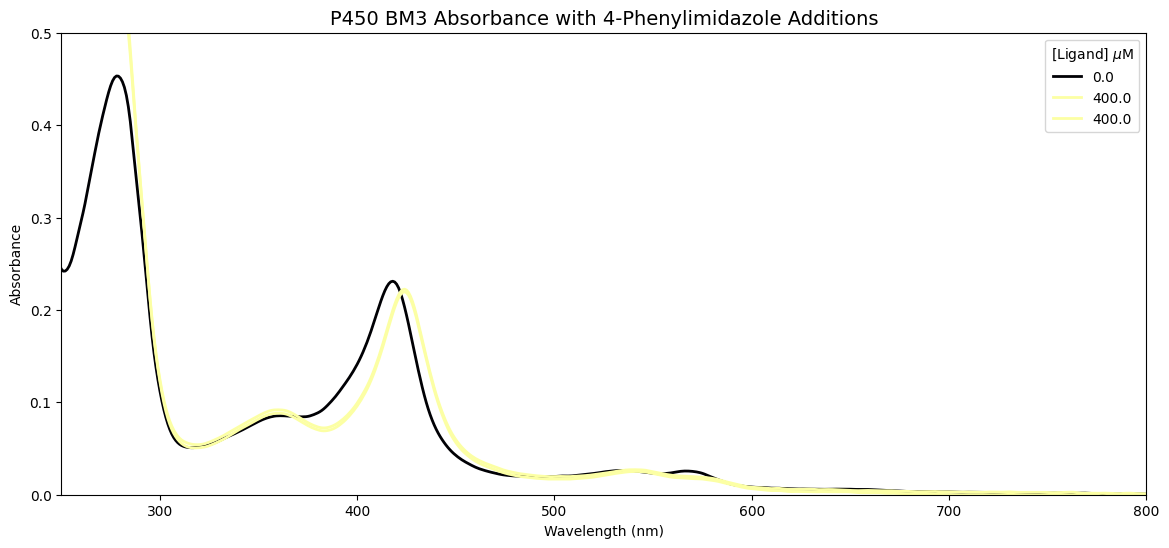

titrations/p450-bm3-4-phenylimidazole-absorbance-only-2.png


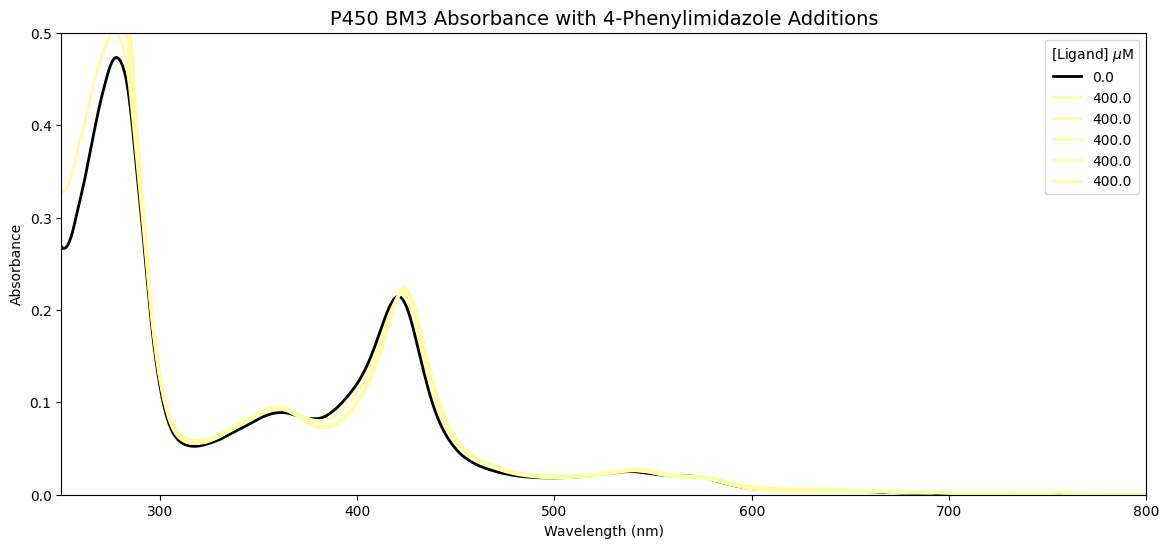

titrations/p450-bm3-4-phenylimidazole-absorbance-only-3.png


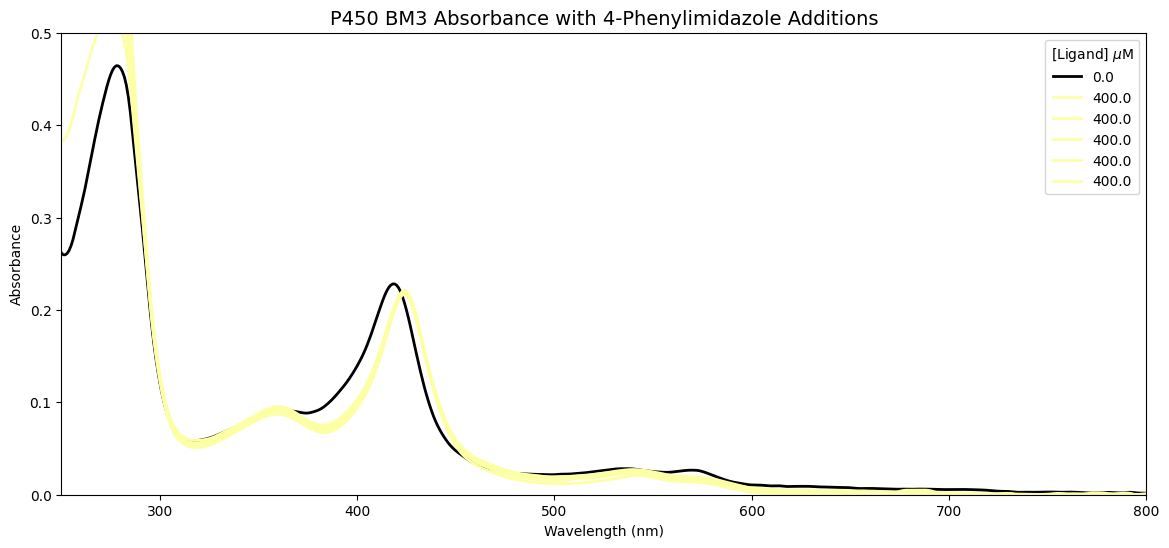

titrations/p450-bm3-4-phenylimidazole-absorbance-only-4.png


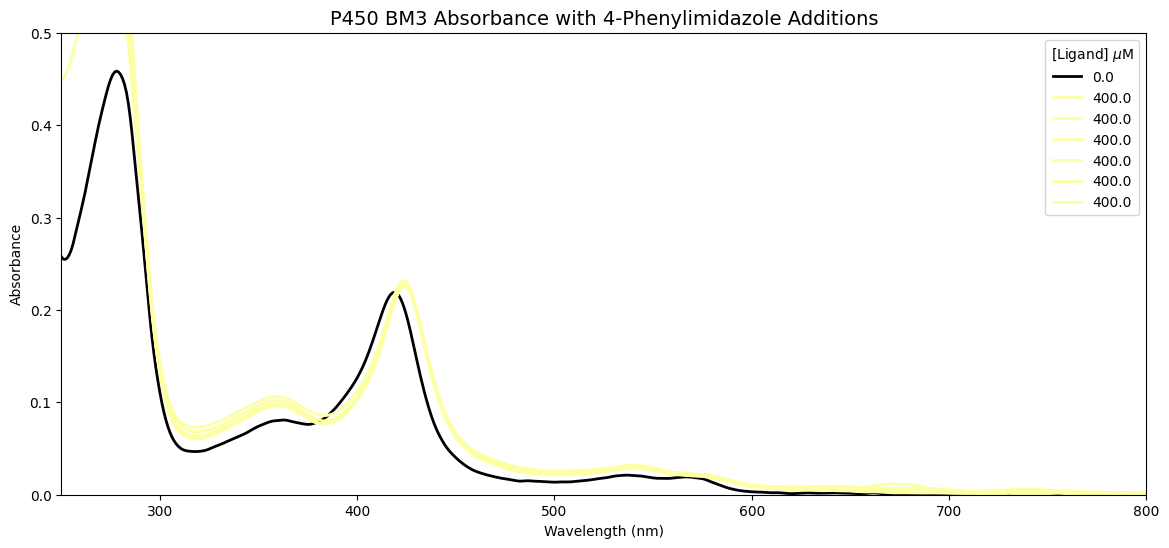

titrations/p450-bm3-4-phenylimidazole-absorbance-only-5.png


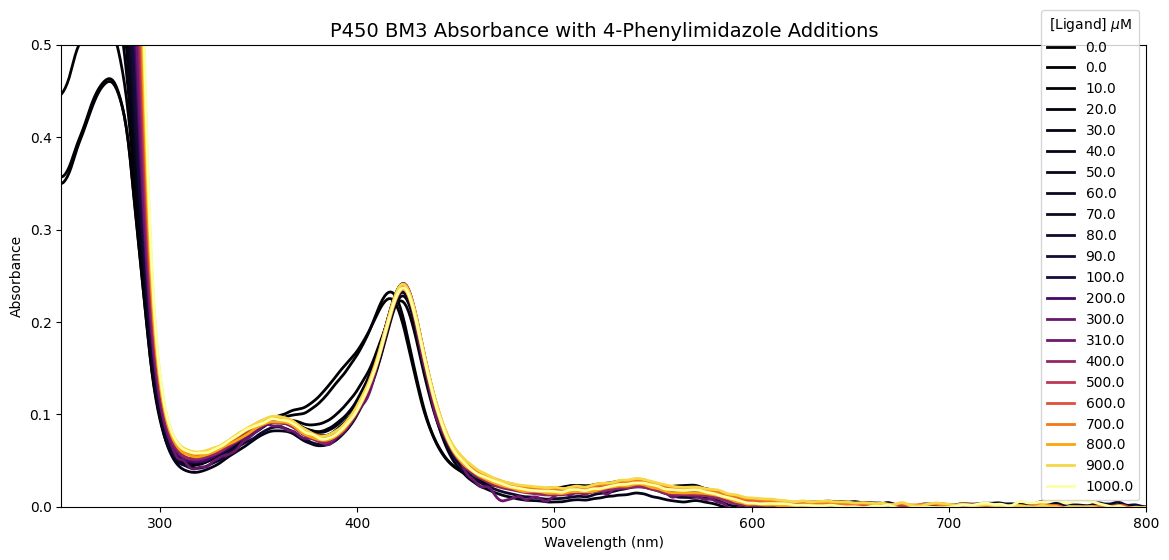

titrations/p450-bm3-4-phenylimidazole-absorbance-only-6.png


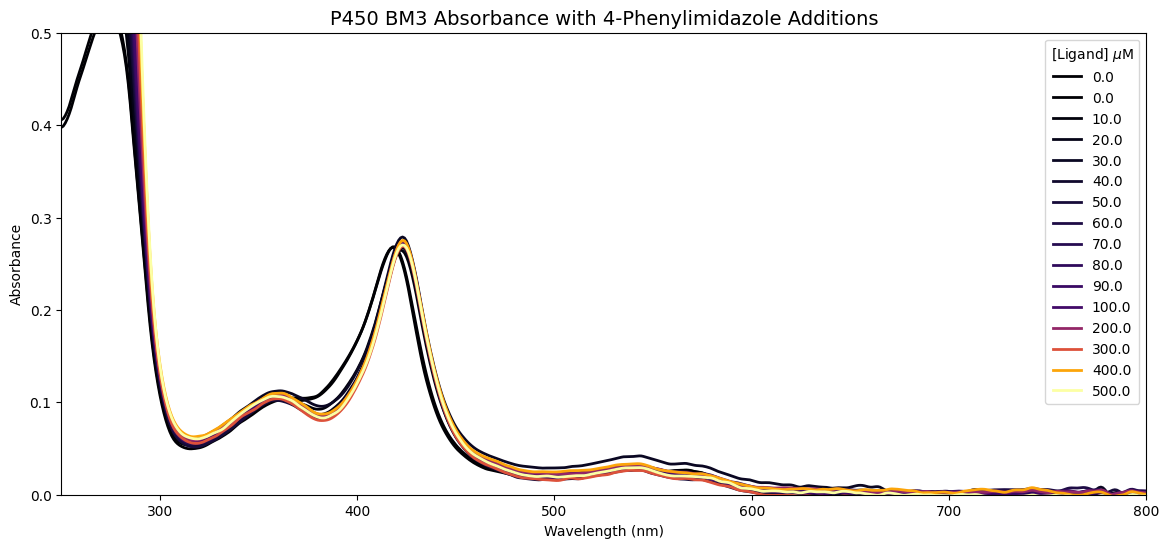

titrations/p450-bm3-4-phenylimidazole-absorbance-only-7.png


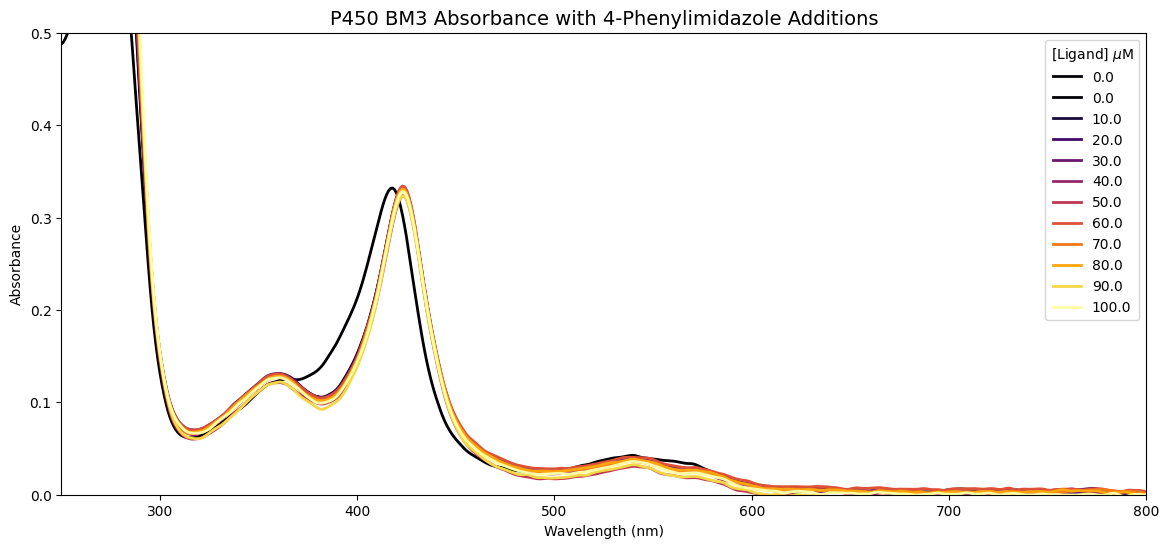

titrations/p450-bm3-4-phenylimidazole-absorbance-only-8.png


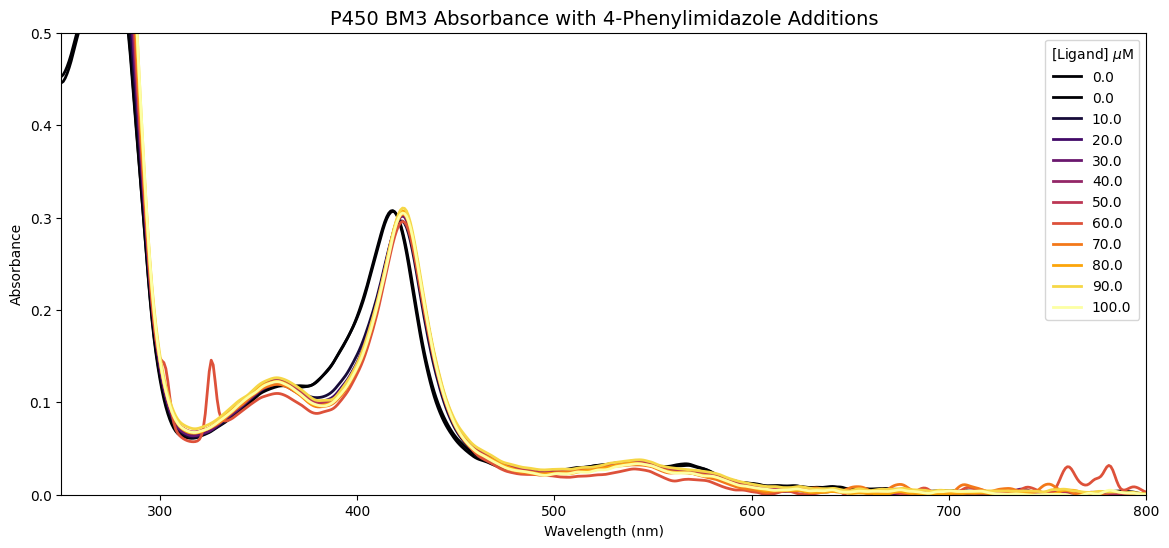

titrations/p450-bm3-4-phenylimidazole-absorbance-only-9.png


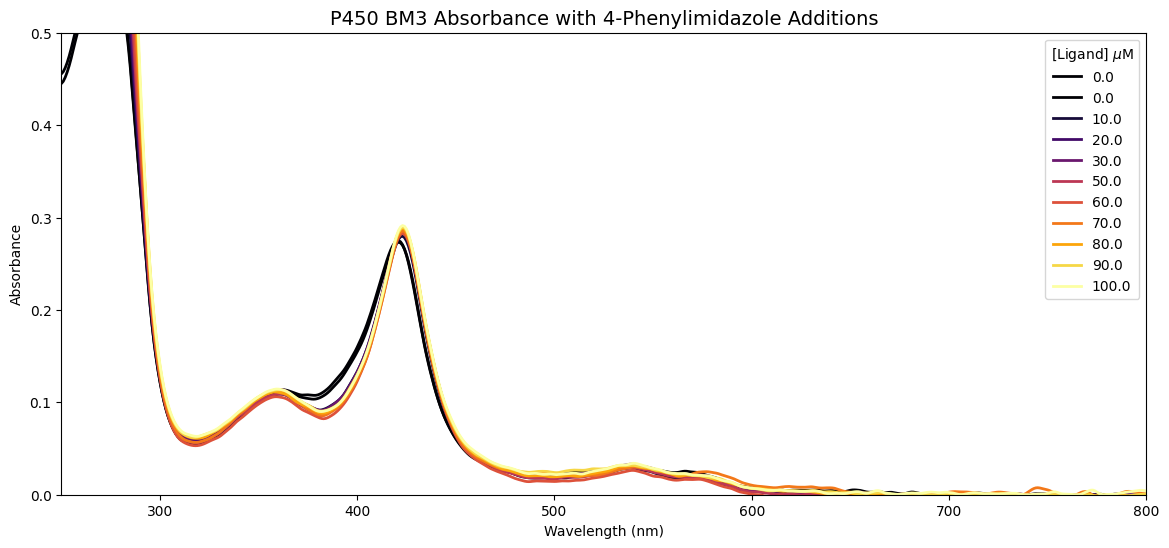

In [5]:
for idx, file in enumerate(experiments['4-Phenylimidazole'], 1):
    # if file ==  experiments['4-Phenylimidazole'][1]:
    df = utils.parse.varian(os.path.join('..', file))

    blank_columns = df.columns.str.contains('blank|baseline', case=False)
    p450_columns = df.columns.str.contains('bm3', case=False) 
    dmso_co1umns = df.columns.str.contains('dmso', case=False) 
    ligand_columns =   df.columns.str.contains(r'(?<=_)[0-9\.]', case=False) & (dmso_co1umns == False)
    use_columns =  dmso_co1umns | ligand_columns
    
    # assert no overlap
    assert not any(ligand_columns & dmso_co1umns & blank_columns & p450_columns)

    # baseline correction
    # df =  df.subtract(df['baseline'], axis=0)
    df =  df.subtract(df.loc[800, :], axis=1)
    
    ligand_volumes = df.columns[ligand_columns].str.extract(r'(?<=_)([0-9\.]+)').astype(float)[0]
    # ligand_volumes = df.columns[ligand_columns].str.extract(r'(?<=_)([0-9]+?\.?[0-9]+)').astype(float)[0]
    ligand_volumes = ligand_volumes.fillna(0)
    
    # assume 10 mM stock
    # concs = np.concat(ligand_volumes * 100 # uM
    concs = np.concatenate([
        np.array([0] * sum(dmso_co1umns)), 
        ligand_volumes
        ]) * 100 # um
    
    # matches plate format, ligands only
    x = df.loc[:, use_columns].T
    
    assert len(concs) == len(x) 
    
    x = pd.DataFrame(gaussian_filter1d(x,
                                       sigma=2,
                                       axis=1,
                                       ),
                     columns=x.columns,
                     index=x.index,
                     )

    concs_scaled = concs - min(concs)
    concs_scaled /= max(concs_scaled)
    
    colors = plt.cm.inferno(concs_scaled)
    fig, ax = plt.subplots(1, 1, 
                           figsize=(14, 6),
                          )
    
    for i in range(len(x)):
        row = x.iloc[i, :]
        ax.plot(row,
                lw=2,
                c=colors[i],
                label=concs[i],
                )
    
    ax.set_xlim(250, 800)
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance')
    ax.set_title(f'P450 BM3 Absorbance with 4-Phenylimidazole Additions', 
                 size=14,
                )
    ax.legend(title='[Ligand] $\mu$M')
    save_file_name = f"p450-bm3-4-phenylimidazole-absorbance-only-{idx}.png"
    save_path = os.path.join(save_dir, save_file_name)
    print(save_path)
    plt.savefig(save_path)
    plt.show()
    plt.close()

In [56]:
list(plt.color_sequences)

['tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'Pastel1',
 'Pastel2',
 'Paired',
 'Accent',
 'Dark2',
 'Set1',
 'Set2',
 'Set3']

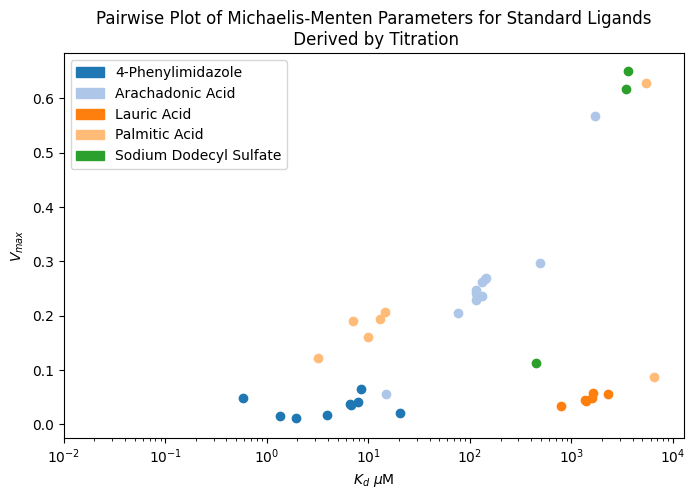

In [67]:
import seaborn as sns
import matplotlib.patches as mpatches


# c_cycle = plt.color_sequences.get('Pastel2')
c_cycle = plt.color_sequences.get('tab20')

plt.figure(figsize=(8, 5))

handles = []
for i, (ligand, group) in enumerate(metrics.groupby('ligand')):
    c = c_cycle[i]
    #ax = sns.kdeplot(x=group['km'],
    #                 y=group['vmax'],
    #                 label=ligand,
    #                 color=c,
    #                )
    plt.scatter(x=group['km'],
                y=group['vmax'],
                color=c,
               )
    handles.append(mpatches.Patch(color=c,  label=f'{ligand}'))

plt.xscale('log')
plt.xlim(10e-3, ax.get_xlim()[1])
# plt.ylim(0, ax.get_ylim()[1])
plt.xlabel('$K_d$ $\mu$M')
plt.ylabel('$V_{max}$')
plt.legend(handles=handles)
plt.title('Pairwise Plot of Michaelis-Menten Parameters for Standard Ligands\n Derived by Titration')
plt.savefig(os.path.join(save_dir, 'mm-titration-scatter.png'))
plt.show()

In [6]:
# bummary = []
# 
# for ligand, group in  summary.groupby('ligand'):
#     
#     cv = group[['vmax', 'km']].apply(lambda x: 100 * x.std() / x.mean())
#     cv.index = [f'{i}_cv%' for i in cv.index]
#     
#     std = group[['vmax', 'km']].std()
#     std.index = [f'{i}_std' for i in std.index]
#     
#     mean = group[['vmax', 'km']].mean()
#     mean.index = [f'{i}_mean' for i in mean.index]
#     
#     o = pd.concat([cv, std, mean])
#     o['ligand'] = ligand
#     o['count'] = len(group)
#     
#     bummary.append(o)
#     
# bummary = pd.concat(bummary, axis=1).T
# 
# bummary = bummary.loc[:, ['ligand', 'count', 'km_mean', 'km_std', 'km_cv%', 'vmax_mean', 'vmax_std', 'vmax_cv%']]
# 
# bummary